# Make globally averaged time series of ocean variables

In [14]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
xr.set_options(enable_cftimeindex=True)

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd


import matplotlib as mpl
import matplotlib.pyplot as plt

#import cartopy.crs as ccrs
#from cartopy.util import add_cyclic_point

import glob


## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(


In [15]:
# define constants

speryr=60*60*24*365

# unit conversion for fgco2 to PgC/yr
# kgC/m2/s * speryr * 1e3 g/kg * 1e-15 Pg/g


ZJperJ = 1e-21


PgperKg = 1e-12

In [16]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

modellist= ['CESM2']

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

modelcolors=['dodgerblue','mediumvioletred','red','olive','cyan','gray']


varlist=['hfds','fgco2']#,'spco2',]
unitslist=['W m-2'] #'kgC m-2 s-1', 



In [17]:
# initialize a dictionary to hold all of the data
data_dict={}

In [18]:
def weighted_temporal_mean(ds, var):
    """
    takes an annual average weighted by days in each month

    Args:
    - dataset: xarray dataset with monthly resolution data
    - var: variable name to be averaged

    Returns:
    - the weighted average

    Example Usage: 
    
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="YS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="YS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

### Load Grid Info

In [19]:
#---- get grid info

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    if model =='GISS_E2.1':
        # no grid data exists at this time
        # do nothing
        print(model +' does not have grid info')
    else:
        print(model +' getting grid info')
    
        # get area of gridcells
        filenamelist= glob.glob(outputdir +model +'/*/*areacella*.nc')
        areacella = xr.open_dataset(filenamelist[0], use_cftime=True)

        # get area of ocean gridcells
        filenamelist= glob.glob(outputdir +model +'/*/*areacello*.nc')
        areacello = xr.open_dataset(filenamelist[0], use_cftime=True)
        if model =='CESM2':
            areacello=areacello*1e-4 # CESM2 has area units of cm2 for ocean

        # add to the dictionary
        data_dict[model +'_areacella'] = areacella
        data_dict[model +'_areacello'] = areacello


CESM2 getting grid info


### Load Data

In [20]:
# this loads all variables in varlist for all experiments in runlist and models in modellist
#modellist=['CESM2']#['NorESM2-LM']
#modellist_safe = ['CESM2']#['NorESM2']

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    # loop over experiments
    for r in range(len(runlist)):
        run = runlist_wc[r]

        # loop over variables
        for v in range(len(varlist)):
            var=varlist[v]
            searchpath= outputdir +model +'/' +run +'/*' +var +'_*.nc'
            if model =='CESM2':
                # all models have a var_ filename except CESM
                searchpath= outputdir +model +'/' +run +'/*' +var +'*.nc'
            
            filenamelist= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim

            # loop over filenames. some variables are stored in multiple files
            # this should be possible with xr.open_mfdataset but it isn't loading all of time points
            for f in range(len(filenamelist)):
                file = filenamelist[f]
                if f==0:
                    dsmerge_f = xr.open_dataset(file, use_cftime=True)
                else:
                    ds = xr.open_dataset(file, use_cftime=True)
                    dsmerge_f=xr.concat([dsmerge_f,ds],dim='time')

            # one model has nbp called nep instead -> add an nbp variable that is a copy of nep
            if 'nep' in dsmerge_f:
                dsmerge_f['nbp'] = dsmerge_f['nep']
                #dsmerge_f = dsmerge_f.drop_vars('nep')
                
            # check units and convert if necessary - at the moment this is just CESM for carbon variables
            #if ds[veg].units != unitslist[v]:
                # the unit does not match what we expect, 
                # convert the unit and update the metadata
            # At the moment this only applies to CESM, but should catch the CESM units and not others
            # flux variables
            # test first to see if the variable exists. nbp is missnamed in one model
            if var in dsmerge_f: 
                if dsmerge_f[var].units == 'gC/m^2/s':
                    dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                    dsmerge_f[var].attrs['units'] = 'kg m-2 s-1'
                # stock variables
                elif dsmerge_f[var].units == 'gC/m^2':
                    dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                    dsmerge_f[var].attrs['units'] = 'kg m-2'
                elif dsmerge_f[var].units == 'mmol/m^3 cm/s':
                    dsmerge_f[var]=dsmerge_f[var]* 1e-8* 12 # convert from mmol/m^3 cm/s to kgC/m2/s 
                    dsmerge_f[var].attrs['units'] = 'kg m-2 s-1'
                    
            else: #var does not exist
                ds=dsmerge_f
                # add a blank variable so that loops work
                if 'time' in ds:
                    nan_dataarray = xr.DataArray(np.full((len(ds['time']),len(ds['lat']), len(ds['lon'])), np.nan), 
                                                 coords={'lon': ds['lon'], 'lat': ds['lat'],'time': ds['time']}, dims=['time','lat', 'lon'])
                else:
                    nan_dataarray = xr.DataArray(np.full((len(ds['year']),len(ds['lat']), len(ds['lon'])), np.nan), 
                             coords={'lon': ds['lon'], 'lat': ds['lat'],'year': ds['year']}, dims=['year','lat', 'lon'])
 
   
                # Assign the new variable to the dataset
                dsmerge_f[var] = nan_dataarray

            
            # merge all variables into one dataset
            # if it's the first variable, then start a new datset, otherwise merge with existing
            if v ==0:
                dsmerge_v = dsmerge_f.copy()
            else:
                dsmerge_v=xr.merge([dsmerge_v, dsmerge_f],compat='override')

            # add a new variable that is the sum of all carbon pools
            if all(var_name in dsmerge_v for var_name in ['cVeg', 'cSoil', 'cLitter']):
                dsmerge_v['cTot'] = dsmerge_v['cVeg'] + dsmerge_v['cSoil'] + dsmerge_v['cLitter']
                
                
        
        # save output to a dictionary
        print('adding ' +model +' ' +runlist[r] +' to dict')
        data_dict[model +'_' +runlist[r]] = dsmerge_v


adding CESM2 flat10 to dict
adding CESM2 flat10_zec to dict
adding CESM2 flat10_cdr to dict


In [21]:
ds=data_dict['CESM2' +'_' +runlist[0]]

In [22]:
ds

<xarray.Dataset>
Dimensions:     (nlat: 384, nlon: 320, time: 2520, d2: 2)
Coordinates:
    TLAT        (nlat, nlon) float64 ...
    TLONG       (nlat, nlon) float64 ...
  * time        (time) object 0001-02-01 00:00:00 ... 0211-01-01 00:00:00
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    hfds        (time, nlat, nlon) float32 ...
    time_bound  (time, d2) object ...
    fgco2       (time, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    title:             b.e21.B1850.f09_g17.FLAT10-esm.001
    history:           Tue May 14 20:13:01 2024: ncatted -O -a long_name,hfds...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-09-01 at 15:42:02.2
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    NCO:               netCDF Operators version 5.1.9 (Homepage = http://nco....

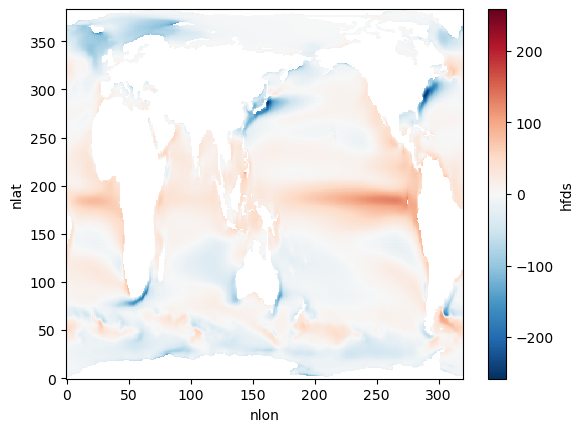

In [23]:
ds.hfds.mean(dim='time').plot()

In [24]:
# areacello is renamed from TAREA

areacello

<xarray.Dataset>
Dimensions:    (nlat: 384, nlon: 320)
Coordinates:
    TLAT       (nlat, nlon) float64 ...
    TLONG      (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    areacello  (nlat, nlon) float64 1.125e+09 1.125e+09 ... 7.431e+08 7.432e+08
Attributes:
    title:             b.e21.B1850.f09_g17.FLAT10-esm.001
    history:           Tue May 14 14:27:19 2024: ncrename -v TAREA,areacello ...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-09-01 at 15:42:02.2
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    NCO:               netCDF Operators version 5.1.9 (Homepage = http://nco....

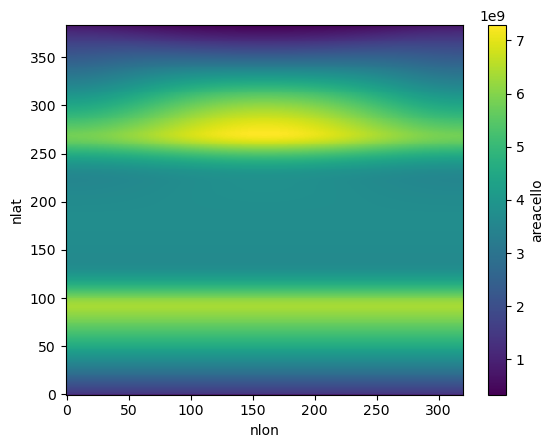

In [25]:
areacello.areacello.plot()

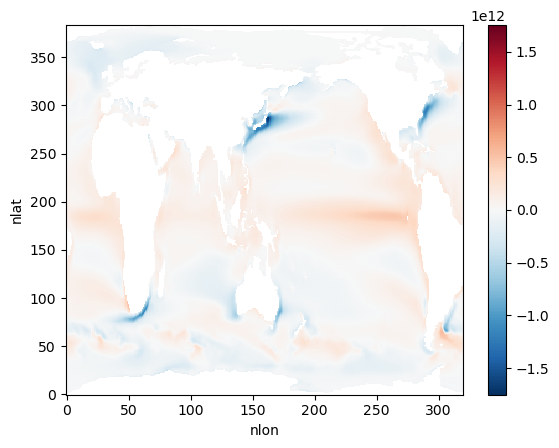

In [26]:
((ds.hfds.mean(dim='time'))*areacello.areacello).plot()

In [28]:
'''
tmp = (ds2015[v] * dz_m_150m).sum(dim='z_t_150m') # units = mmolC/m2
tmp = tmp * area_m2 # units = mmol C/gridcell
tmp = tmp.sum(dim=('nlon','nlat')) # mmol C in the ocean
'''

"\ntmp = (ds2015[v] * dz_m_150m).sum(dim='z_t_150m') # units = mmolC/m2\ntmp = tmp * area_m2 # units = mmol C/gridcell\ntmp = tmp.sum(dim=('nlon','nlat')) # mmol C in the ocean\n"

In [29]:
area_m2=areacello.areacello

heatflux_Wm2=ds.hfds # in units of W/m2

total_heatflux_W=heatflux_Wm2*area_m2



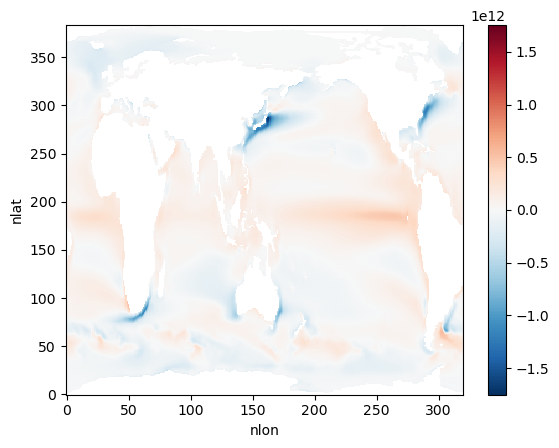

In [30]:

total_heatflux_W.mean(dim='time').plot()

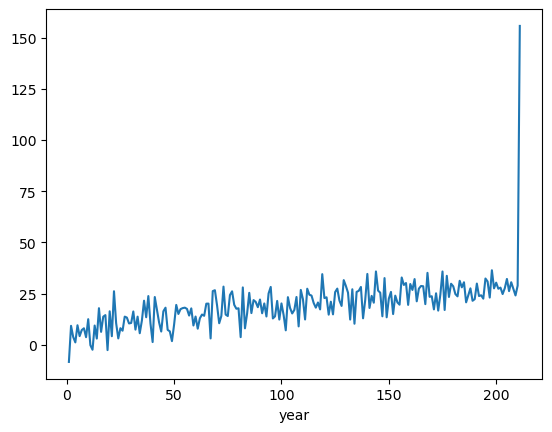

In [34]:
# W/m2 = J/m2/s => *speryr * 1e-21 ZJ/J * m2 of ocean = ZJ/yr

total_heatflux_ZJyr=total_heatflux_W*ZJperJ*speryr


global_heatflux_ZJyr = total_heatflux_ZJyr.sum(dim=['nlat','nlon'])


#average from monthly to annual resolution wihtout accounting for different month lengths
global_heatflux_ZJyr.groupby(ds['time.year']).mean(dim='time').plot()

In [35]:
# proper time averaging accounting for different month lengths
global_heatflux_annual_ZJyr=(weighted_temporal_mean(ds,'hfds')*area_m2*ZJperJ*speryr)

Text(0, 0.5, 'Ocean Heat Flux [ZJ/yr]')

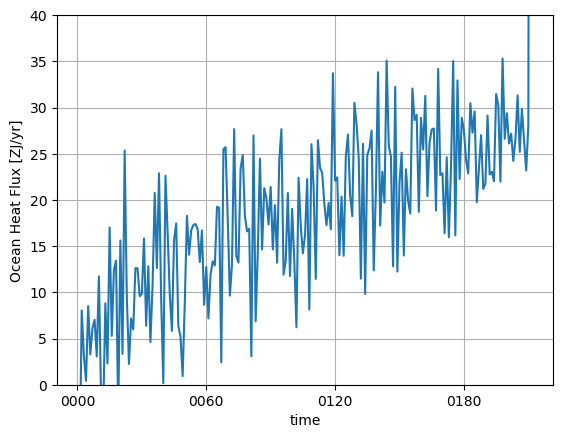

In [36]:
global_heatflux_annual_ZJyr.sum(dim=['nlat','nlon']).plot()
plt.grid()
plt.ylim([-0, 40])
plt.ylabel('Ocean Heat Flux [ZJ/yr]')

In [37]:
#ts=global_heatflux_annual_ZJyr.sum(dim=['nlat','nlon']).rolling(time=10).mean()

#ts

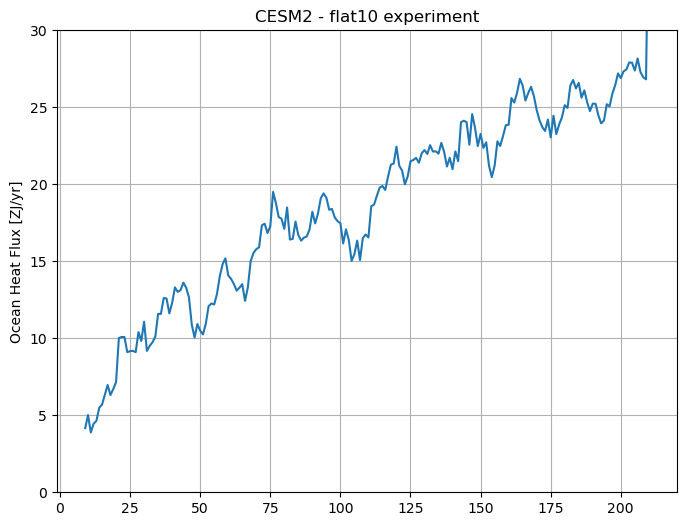

In [33]:
fig = plt.figure(figsize=(8,6))

ts=global_heatflux_annual_ZJyr.sum(dim=['nlat','nlon']).rolling(time=10).mean()
plt.plot(ts)
plt.grid()
plt.ylim([-0, 30])
plt.ylabel('Ocean Heat Flux [ZJ/yr]')
plt.title('CESM2 - flat10 experiment')
# save the plot
fig.savefig('figures/' 'oceanheatflux_CESM2_flat10' +'.png', bbox_inches='tight', dpi=1200)


In [34]:
# proper time averaging accounting for different month lengths
global_carbonflux_annual=(weighted_temporal_mean(ds,'fgco2')*area_m2*PgperKg*speryr)

Text(0, 0.5, 'Ocean carbon flux [PgC/yr]')

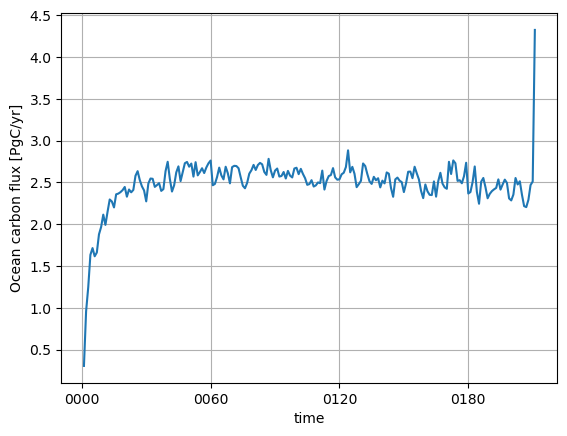

In [35]:
global_carbonflux_annual.sum(dim=['nlat','nlon']).plot()
plt.grid()
plt.ylabel('Ocean carbon flux [PgC/yr]')

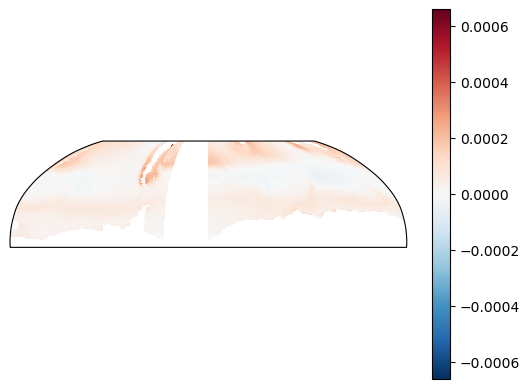

In [36]:
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Robinson()))
ax=axis

#pc=ax.pcolormesh(lon, lat, field, cmap='terrain',vmin=350,vmax=450,transform=ccrs.PlateCarree())
#    ax.coastlines('110m',linewidth=0.5)

global_carbonflux_annual.mean(dim='time').plot(ax=axis,transform=ccrs.PlateCarree())




In [37]:
## alternative area calculation
import pop_tools

ds_grid = pop_tools.get_grid('POP_gx1v7')
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
areaA_m2 = area * 1.e-4
dz_m = ds_grid.dz * 0.01

In [38]:
alt_global = ds.hfds * areaA_m2 *speryr *ZJperJ# units = W/gridcell
alt_global_sum = alt_global.sum(dim=('nlon','nlat')) # mmol C in the ocean

Text(0.5, 1.0, 'Alternative calculation using pop tools')

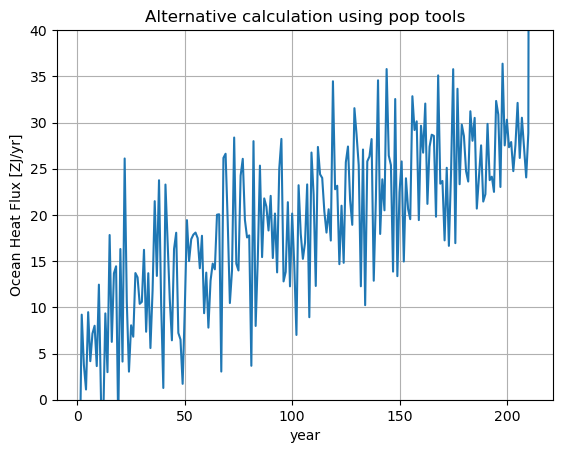

In [39]:
alt_global_sum.groupby(ds['time.year']).mean(dim='time').plot()
plt.grid()
plt.ylim([-0, 40])
plt.ylabel('Ocean Heat Flux [ZJ/yr]')
plt.title('Alternative calculation using pop tools')

In [40]:
alt_global_sum

<xarray.DataArray (time: 2520)> Size: 20kB
array([122.59805054,  89.26921305, 115.15446606, ..., 153.26251381,
       166.89550201, 155.79751246])
Coordinates:
  * time     (time) object 20kB 0001-02-01 00:00:00 ... 0211-01-01 00:00:00

In [41]:
# check a different CESM2 run for a BHIST run
from glob import glob


case1 = 'b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001'
path1 = '/glade/campaign/cesm/community/bgcwg/HOPE/' + case1 + '/ocn/proc/tseries/month_1'

variables = ['SHF']


files = []

for var in variables:

    files.extend(sorted(glob(f'{path1}/{case1}.pop.h.{var}.185001-201412.nc')))

ds = xr.open_mfdataset(files,decode_times=True,decode_coords=False, combine='nested')

## fix time bounds
ds['time'] = ds.time_bound.compute().mean(dim="d2")

/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid

In [42]:
ds['SHF']

<xarray.DataArray 'SHF' (time: 1980, nlat: 384, nlon: 320)> Size: 973MB
dask.array<open_dataset-SHF, shape=(1980, 384, 320), dtype=float32, chunksize=(1, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 16kB 1850-01-16 13:00:00.000001 ... 2014-12-16 12:...
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Total Surface Heat Flux, Including SW
    units:         watt/m^2
    coordinates:   TLONG TLAT time
    grid_loc:      2110
    cell_methods:  time: mean

In [53]:
# proper time averaging accounting for different month lengths
global_heatflux_annual_ZJyr_HOPE=(weighted_temporal_mean(ds,'SHF')*area_m2*ZJperJ*speryr)

In [54]:
arg=global_heatflux_annual_ZJyr_HOPE.sum(dim=['nlat','nlon'])


Text(0.5, 1.0, 'Historical BHIST HOPE run')

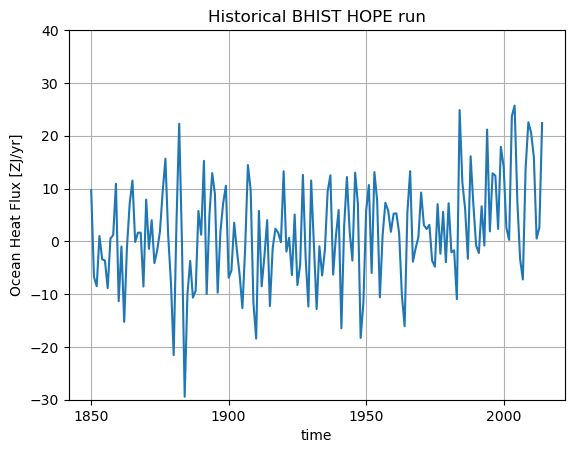

In [55]:
arg.plot()
plt.grid()
plt.ylim([-30, 40])
plt.ylabel('Ocean Heat Flux [ZJ/yr]')
plt.title('Historical BHIST HOPE run')




In [52]:
arg

<xarray.DataArray (time: 165)> Size: 1kB
dask.array<sum-aggregate, shape=(165,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1kB 1850-01-01 00:00:00 ... 2014-01-01 00:00:00

ValueError: Input could not be cast to an at-least-1D NumPy array

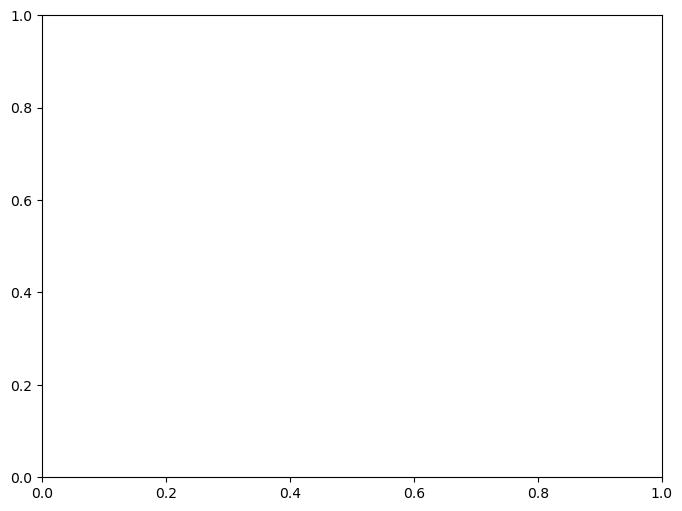

In [51]:
fig = plt.figure(figsize=(8,6))

ts=arg.rolling(time=10).mean()
plt.plot(ts)
plt.grid()
plt.ylim([-30, 40])
plt.ylabel('Ocean Heat Flux [ZJ/yr]')
plt.title('Historical BHIST HOPE run')


# save the plot
fig.savefig('figures/' 'oceanheatflux_CESM2_BHIST_HOPE' +'.png', bbox_inches='tight', dpi=1200)
